In [24]:
import numpy as np
import scipy
import matplotlib as plt

In [25]:
def T_Area(x1, x2, y1, y2):
    # Retourne l'aire du triangle formé par x et y
    #produit élément par élément
    a = 1/2 * abs(x1 * y2 - x2 * y1)
    return a

In [26]:
from scipy.sparse import diags

def Lagrangien(X, X0, M, K, P, Nsx, Nsy):
    # X est l'ensemble des n points, les m premiers sont les points fixes.
    # m est le nombre de points fixes.
    # X0 est la configuration initiale des points fixes.
    # M est la matrice n x n, d'adjacence des points: Mij=1 siles points i et j sont connectés, et 0 sinon
    # K est la matrice donnant les constantes de raideur (réel s'il n'y en a qu'une).
    # P est la pression du sang.
    # On a besoin des vecteurs normaux Ns au côtés où il y a du sang, ils sont orientés vers le côté où il n'y a pas de sang,
    # Nsx sont leurs abscisses
    # Nsy leurs ordonnées
    # Assignation des variables utiles
    
    
    #Mine:
    from scipy.sparse import lil_matrix
    
    #invent=lil_matrix((len(X0),len(X0)), dtype=np.float64)
    #diag=X0[:, 0].flatten()
    #invent.setdiag(diag,k=0)
    
    
    

    diagx=X[:, 0].flatten()
    diagy=X[:, 1].flatten()
    
    x=lil_matrix((len(X),len(X)), dtype=np.float64)
    x.setdiag(diagx,k=0)
    y = lil_matrix((len(X),len(X)), dtype=np.float64)
    y.setdiag(diagy,k=0)
    
    
    diagx0=X0[:, 0].flatten()
    diagy0=X0[:, 1].flatten()
    
    
    x0=lil_matrix((len(X0),len(X0)), dtype=np.float64)
    x0.setdiag(diagx0,k=0)
    y0 = lil_matrix((len(X0),len(X0)), dtype=np.float64)
    y0.setdiag(diagy0,k=0)


    
    #x = diags(X[:, 0])
    #y = diags(X[:, 1])
    #x0 = diags(X0[:, 0])
    #y0 = diags(X0[:, 1])
    
    
    
    xv = x - x0
    yv = y - y0
    dx = M.dot(x) - x.dot(M)
    dy = M.dot(y) - y.dot(M)
    dx0 = M.dot(x0) - x0.dot(M)
    dy0 = M.dot(y0) - y0.dot(M)
    
    

    # Calcul de l'énergie potentielle due aux ressorts
    wt = 0.5 * np.sum(K * ((np.sqrt(dx.power(2) + dy.power(2)) - np.sqrt(dx0.power(2) + dy0.power(2))).power(2)))
    
    # Calcul de l'énergie potentielle due à la pression du sang
    wp = 0.0
    Ms = np.abs(Nsx) + np.abs(Nsy) != 0  # Matrice qui vaut 1 si le lien ij est en contact avec du sang

    O1 = 2.0 * ((Nsx.dot(xv) + Nsy.dot(yv)) > 0.0) - Ms  # Matrice qui permettra de compter positivement ou négativement les aires
    wp += np.sum(T_Area(xv.dot(M), dx, yv.dot(M), dy) * O1)

    O2 = 2.0 * ((xv.dot(Nsx) + yv.dot(Nsy)) > 0.0) - Ms
    wp += np.sum(T_Area(xv.dot(M), dx0, yv.dot(M), dy0) * O2)

    res = np.sum(wt) - P * np.sum(wp)
    return res


In [27]:
import matplotlib.pyplot as plt
import numpy as np

def Trace(X, X0, M, P, Nsx, Nsy, LL):
    plt.figure()

    plt.scatter(X0[:, 0], X0[:, 1])
    #plt.hold(True)
    plt.scatter(X[:, 0], X[:, 1])

    Ms = np.abs(Nsx) + np.abs(Nsy) != 0
    Li, Lj = np.nonzero(Ms)
    
    
    
    for k0, k1 in zip(Li,Lj):
        plt.plot([X[k0, 0], X[k1, 0]], [X[k0, 1], X[k1, 1]], 'r')

    #for k in np.concatenate((i, j)):
        #plt.plot([X[k[0], 0], X[k[1], 0]], [X[k[0], 1], X[k[1], 1]], 'r')

    
    Pi, Pj = np.nonzero(M - Ms)

    for k0, k1 in zip(Pi,Pj):
        plt.plot([X[k0, 0], X[k1, 0]], [X[k0, 1], X[k1, 1]], 'g')

    plt.legend(['Points initiaux X0', 'Points à l\'équilibre', 'Membrane à l\'équilibre'], loc='lower right')
    plt.title(f'Représentation à l\'équilibre pour une pression de {P} bars')
    plt.axis('equal')

    plt.figure()
    plt.plot(LL[:, 0])
    plt.title('J en fonction du nombre d\'itérations')
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('-L (Lagrangien')

    plt.figure()
    plt.scatter(np.arange(1, len(LL) + 1), LL[:, 1])
    plt.title('(cd1)')
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('norm(X_(k+1) - X_(k))')

    plt.figure()
    plt.scatter(np.arange(1, len(LL) + 1), LL[:, 2])
    plt.title('cd2')
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('norm(Grad(Xk))')
    plt.show()


In [28]:
def permut_M_adj(M, i, j):
    # On échange les lignes et les colonnes de M
    Mp = M.copy()
    li = M[i, :]
    lj = M[j, :]
    ci = M[:, i]
    cj = M[:, j]
    Mp[i, :] = lj
    Mp[j, :] = li
    Mp[:, i] = cj
    Mp[:, j] = ci
    return Mp

In [29]:
def dicho(f, a, b):
    c = (a + b) / 2
    while abs(a - c) > 1e-13:
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        c = (a + b) / 2
    x = c
    return x

In [30]:
def ajout_tendons(g, X0, M, K, K1, cK, sens, n_arbo, n_reel):
    X0t = X0.copy()
    Mt = M.copy()
    Kt = K.copy()
    seuil = 0

    for i in range(1, n_arbo + 1):
        seuil += (i - 1)

        for j in range(1, i + 1):
            ai = 0.25 - (i - 1) * 0.15 / n_arbo
            bi = 0.35 + i * 0.3 / n_arbo

            X0t[j + seuil, 0] = sens * (ai + (j - 1) / i * bi)
            X0t[j + seuil, 1] = (n_arbo - i + 1) * g(0) * 2

            if i < n_arbo:
                Mt[j + seuil, j + i + seuil] = 1
                Mt[j + seuil, j + i + seuil + 1] = 1
                Kt[j + seuil, j + i + seuil] = K1 * cK
                Kt[j + seuil, j + i + seuil + 1] = K1 * cK
            elif j == 1:
                Mt[j + seuil, j + i + seuil] = 1
                Mt[j + seuil, j + i + seuil + n_reel // 2] = 1
                Kt[j + seuil, j + i + seuil] = K1 * cK
                Kt[j + seuil, j + i + seuil + n_reel // 2] = K1 * cK
            elif j > 1:
                Mt[j + seuil, j + i + seuil + n_reel * (1 // 3 + j / (2 * n_arbo) * 2 // 3)] = 1
                Mt[j + seuil, j + i + seuil + n_reel * (1 // 3 + (j + 1) / (2 * n_arbo) * 2 // 3)] = 1
                Kt[j + seuil, j + i + seuil + n_reel * (1 // 3 + j / (2 * n_arbo) * 2 // 3)] = K1 * cK
                Kt[j + seuil, j + i + seuil + n_reel * (1 // 3 + (j + 1) / (2 * n_arbo) * 2 // 3)] = K1 * cK

    return X0t, Mt, Kt


In [31]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse import lil_matrix

def Mesh_g2(g, n, pas, ntendons, K1):
    ntot = n + ntendons
    xk = 0

    # Initialize X0, Vsx, and other variables
    #Vsx = np.zeros(ntot)
    Vsx = np.zeros(((ntot-1),1))
    d = 0
    X0 = np.vstack((np.zeros((ntendons, 2)), np.array([xk, g(xk)]).reshape(1, 2), np.zeros((n - 1, 2))))
    
    #en language python, je veux aller de ntendons à ntot-2, en terme de boucle, le upper bound doit etre décaler par 1
    for k in range(ntendons,(ntot-2)+1):
        d = d + pas
        f=lambda x: (xk-x)**2+(g(xk)-g(x))**2-pas**2
        xk_new = dicho(f, xk, pas + xk)
        Vsx[k] = -(g(xk_new) - g(xk)) / (xk_new - xk)
        xk = xk_new
        X0[k+1,:] = [xk,g(xk)]
        if xk > 1:
            break
            
    k=ntot-1     #pas très sure        
    n_reel=(ntot-1)-ntendons
    X0 = X0[:(ntot-2)+1, :]
    Vsx = Vsx[:(ntot-2)-1+1]
    
    nsx = lil_matrix((len(Vsx)+1,len(Vsx)+1), dtype=np.float64)
    nsx.setdiag(Vsx,k=1)   
    Nsx=nsx
    
    
    diagonal = np.concatenate((np.zeros((ntendons,1)), np.ones((k-1-ntendons,1))))
    diagonal=diagonal.flatten()   #when you create the x array using np.concatenate,
                                  #it results in a two-dimensional array with shape (m, 1),
                                  #and when you pass it to diags, it's expecting a one-dimensional array.

    M = lil_matrix((len(Vsx)+1,len(Vsx)+1), dtype=np.float64)
    M.setdiag(diagonal,k=1) #matrice creuse carrré de 42X42
    
    
    Nsy = M.copy()
    K = n_reel * K1 * M
    
    
    import math

    for k in range(ntendons):
        ind = math.floor((k+1) * n_reel / (ntendons + 1)) + ntendons
        M[k,ind-1]=1
        K[k,ind-1] = n_reel*K1*10
        
        if k==0:
            K[k,ind-1]= n_reel*K1*2
            
                
        X0[k,0] = (k+1)/(2*ntendons)
        X0[k,1] = g(0)
    
    return(X0,M,Nsx,Nsy,K,n_reel)
        


In [32]:
def Parabolic_iterpolation(q, x, y, z, ite):
    for k in range(ite):
        xy = (q(y) - q(x)) / (y - x)
        yz = (q(z) - q(y)) / (z - y)
        
        if xy == 0 or yz == 0:
            break
        
        xyz = (yz - xy) / (z - x)
        y1 = (x + y) / 2 - xy / (2 * xyz)
        
        if y1 < y:
            z = y
            y = y1
        else:
            x = y
            y = y1

    if y > 0:
        t = y
    else:
        t = 1e-10
    
    return t


In [33]:
import numpy as np

def norm_X(X):
    N = np.sqrt(np.sum(np.sum(X**2) / len(X)))
    return N


In [34]:
import numpy as np

def Grad(J, X, h):
    n = len(X)
    H = np.zeros((n, 2))
    dJ = np.zeros((n, 2))

    for i in range(n):
        H[i, 0] = h
        dJ[i, 0] = (J(X + H) - J(X - H) / (2 * h)
        H[i, 0] = 0

        H[i, 1] = h
        dJ[i, 1] = (J(X + H) - J(X - H)) / (2 * h)
        H[i, 1] = 0

    dj = dJ
    return dj


SyntaxError: invalid syntax (1313319528.py, line 11)

In [35]:
import numpy as np

def Polak_Ribiere_2D(J, X_init, ite_max, errdf):
    # Retourne le minimum de la fonction J en partant de X0 par la méthode de Polak -Ribière

    # J la fonctionelle à minimiser
    # X0 le point de départ
    # ite_max le nombre d'itération maximale
    h = 1e-5
    tk = 1
    Xk = X_init
    dfk = Grad(J, Xk, h)
    dk = -dfk
    k = 0
    LL = np.zeros((ite_max, 3))

    while tk * np.linalg.norm(dk) > errdf[0] and np.linalg.norm(dfk) > errdf[1]:   #augmenter epsilon
        k += 1
        LL[k-1, 0] = J(Xk)
        if k >= ite_max:    #avec fabien: >= au lieu de >
            print('ite_max dépassé')
            break

        q = lambda t: J(Xk + t * dk)
        tk = Parabolic_iterpolation(q, 0, 30, 120, 4)
        Xk = Xk + tk * dk  # mise à jour de Xk

        dfk1 = Grad(J, Xk, h)
        dfk = np.concatenate((dfk[:, 0], dfk[:, 1]))  # On aligne pour faire le produit matriciel
        
        
        
        #    beta = max(0,-(([dfk1(:,1) ; dfk1(:,2)]-dfk)'*dfk)/(dfk'*dfk));

        beta = max(0, -np.dot((np.concatenate((dfk1[:, 0], dfk1[:, 1])) - dfk).transpose(), dfk) / np.dot(dfk.transpose(), dfk))


        
        
        
        dk = -dfk1 + beta * dk
        dfk = dfk1
        LL[k-1, 1] = np.linalg.norm(tk * dk)
        LL[k-1, 2] = np.linalg.norm(dfk)

    X = Xk
    ite = min(k, ite_max)
    LL = LL[:ite, :]
    name = 'Polak-Ribière'
    
    return X, ite, name, LL
    
    

In [36]:
# Définition des conditions initiales

# Maillage de la demi-valve
n = 5
pas = 1/n
ntendons = 0
m = 2+ntendons

K1 = 1/200
P = 0.001

# Définition des paramètres de la fonctions représentant la demi-valve
e = 0.4
s = 0.35
sens = 1
# Define the half-valve function
def g(x):
    return (-np.log((x + e) / (s + e))**2) * (x < s)

#X0, M, Nsx, Nsy, K, n_reel = Mesh_g2(g, n, pas, ntendons, K1)
res= Mesh_g2(g, n, pas, ntendons, K1) #res comme résultat

X0= res[0]
M= res[1]
Nsx= res[2]
Nsy= res[3]
K= res[4]
n_reel= res[5]





n_tot = n_reel + ntendons
print("\n")
print("***************************************************\n")
print("\n")
print(' Nombre de points générés : ' + str(n_reel) + '\n')


#Définition des paramètres utiles
X02 = X0[ntendons+1].copy()
X0[ntendons+1] = X0[n_tot-1].copy()
X0[n_tot-1] = X02.copy()

M = permut_M_adj(M, ntendons+1, n_tot-1)
Nsx = permut_M_adj(Nsx, ntendons+1, n_tot-1)
Nsy = permut_M_adj(Nsy, ntendons+1, n_tot-1)
K = permut_M_adj(K, ntendons+1, n_tot-1)       #so far so good

#Résolution du problème

import time

# Define the objective function J
def J(XM):
    return Lagrangien(np.vstack((X0[:m, :], XM)), X0, M, K, P, Nsx, Nsy)

# Set parameters
ite_max = 2000
errdf = [1e-3, 2 * 1e-4 ]

# Measure time
start_time = time.time()

# Call the Polak-Ribiere optimizer
XM, ite, name, LL= Polak_Ribiere_2D(J, X0[m:n_tot], ite_max, errdf)   #could be X0[m:n_tot]

# Calculate execution time
time = time.time() - start_time
# Combine X0 and XM to form X
X = np.vstack((X0[:m, :], XM))


Trace(X, X0, M, P, Nsx, Nsy, LL)


# Calculate execution time in seconds
execution_time = time

# Print results
print("La méthode de " + name + " a pris : " + str(execution_time) + " secondes")
print("Nombre d'itérations : " + str(ite))




***************************************************



 Nombre de points générés : 4



NameError: name 'Grad' is not defined

In [38]:
denseK = K.toarray()
denseK

array([[0.  , 0.  , 0.  , 0.02],
       [0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.  ]])

In [39]:
np.save('minidenseK.npy', denseK)


In [41]:
denseM = M.toarray()
#denseX0 = X0.toarray()
denseNsx = Nsx.toarray()
denseNsy = Nsy.toarray()

In [43]:
np.save('minidenseNsx.npy', denseK)
np.save('minidenseNsy.npy', denseK)
np.save('minidenseM.npy', denseK)


In [44]:
X0

array([[ 0.        , -0.39514885],
       [ 0.39058801, -0.        ],
       [ 0.19739929, -0.05175055],
       [ 0.07452104, -0.20955085]])

In [31]:
denseM = M.toarray()
denseM


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [236]:
denseNsx = Nsx.toarray()
denseNsx

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -3.06543454],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -2.91185765, ...,  0.        ,
         0.        ,  0.        ]])

In [237]:
denseNsy = Nsy.toarray()
denseNsy

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [239]:
np.save('denseM.npy', denseM)
np.save('denseNsx.npy', denseNsx)
np.save('denseNsy.npy', denseNsx)
#to import = np.load('denseNsy.npy')


np.save('M.npy', M)
np.save('Nsx.npy', Nsx)
np.save('Nsy.npy', Nsx)




In [51]:
#je dois tester pour différentes valeurs de P et trouver les valeurs extremes pour lesquelles ça marche
#comme ça j'ai ma plage de valeurs de P, à discrétiser

#avant cette étape, il faut s'assurer que le code est fonctionnel: se débarasser des problèmes aux bords



n = 5
pas = 1/n
ntendons = 0
m = 2+ntendons

K1 = 1/200
P = 0.001

# Définition des paramètres de la fonctions représentant la demi-valve
e = 0.4
s = 0.35
sens = 1
# Define the half-valve function
def g(x):
    return (-np.log((x + e) / (s + e))**2) * (x < s)

#X0, M, Nsx, Nsy, K, n_reel = Mesh_g2(g, n, pas, ntendons, K1)
res= Mesh_g2(g, n, pas, ntendons, K1) #res comme résultat

X0= res[0]
M= res[1]
Nsx= res[2]
Nsy= res[3]
K= res[4]
n_reel= res[5]





n_tot = n_reel + ntendons
print("\n")
print("***************************************************\n")
print("\n")
print(' Nombre de points générés : ' + str(n_reel) + '\n')


#Définition des paramètres utiles
X02 = X0[ntendons+1].copy()
X0[ntendons+1] = X0[n_tot]
X0[n_tot] = X02

M = permut_M_adj(M, ntendons+2, n_tot)
Nsx = permut_M_adj(Nsx, ntendons+2, n_tot)
Nsy = permut_M_adj(Nsy, ntendons+2, n_tot)
K = permut_M_adj(K, ntendons+2, n_tot)

#Résolution du problème

import time

# Define the objective function J
def J(XM):
    return Lagrangien(np.vstack((X0[:m, :], XM)), X0, M, K, P, Nsx, Nsy)

# Set parameters
ite_max = 2000
errdf = [1e-10 / n, 2 * 1e-4 / n]

# Measure time
start_time = time.time()

# Call the Polak-Ribiere optimizer
XM, ite, name, LL= Polak_Ribiere_2D(J, X0[m-1:n_tot], ite_max, errdf)   #could be X0[m:n_tot]

# Calculate execution time
time = time.time() - start_time
# Combine X0 and XM to form X
X = np.vstack((X0[:m, :], XM))


Trace(X, X0, M, P, Nsx, Nsy, LL)


# Calculate execution time in seconds
execution_time = time

# Print results
print("La méthode de " + name + " a pris : " + str(execution_time) + " secondes")
print("Nombre d'itérations : " + str(ite))




***************************************************



 Nombre de points générés : 4



IndexError: index 4 is out of bounds for axis 0 with size 4

In [53]:
np.save('miniX0.npy', X0)


In [52]:
len(X0)

4

In [ ]:
###############################

In [ ]:
############################

In [3]:
import numpy as np

M=np.load('denseM.npy')
Nsx=np.load('denseNsx.npy')
Nsy=np.load('denseNsy.npy')
X0=np.load('X0.npy')



In [1]:
#ici le X est : x1, x2, ..., x78,y1, ..., y78
import pandas as pd
import numpy as np

# Charger les données depuis le fichier CSV
df = pd.read_csv('yarab.csv')

# Regrouper les colonnes X_1, X_2, ..., X_78 en une seule colonne X
df['X'] = df.iloc[:, 1:].apply(lambda row: np.array(row.dropna()), axis=1)

# Supprimer les colonnes X_1, X_2, ..., X_78
df = df.drop(df.iloc[:, 1:79], axis=1)

# Afficher le DataFrame résultant
#print(df)


In [4]:
#X= df.at[100, 'X']
#len(X) good 78

#x=X[:39]
#y=X[39:]

#final=np.column_stack((x, y))
#final


#res = tf.concat([tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1)], axis=-1)
#res.numpy()

In [139]:
alpha=df.at[100, 'X']
from scipy.sparse import lil_matrix
x=lil_matrix((len(alpha),len(alpha)), dtype=np.float64)
x.setdiag(alpha,k=0)
x

<78x78 sparse matrix of type '<class 'numpy.float64'>'
	with 76 stored elements in List of Lists format>

In [150]:
from tensorflow.keras import backend as Keras

C:\Users\samya\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch 1/20
40/40 [==============================] - 2s 11ms/step - loss: 0.1284 - val_loss: 0.0916
Epoch 2/20
40/40 [==============================] - 0s 5ms/step - loss: 0.0620 - val_loss: 0.0404
Epoch 3/20
40/40 [==============================] - 0s 4ms/step - loss: 0.0343 - val_loss: 0.0235
Epoch 4/20
40/40 [==============================] - 0s 4ms/step - loss: 0.0174 - val_loss: 0.0087
Epoch 5/20
40/40 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 6/20
40/40 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 7/20
40/40 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 8/20
40/40 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 9/20
40/40 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 10/20
40/40 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 11/20
40/40 

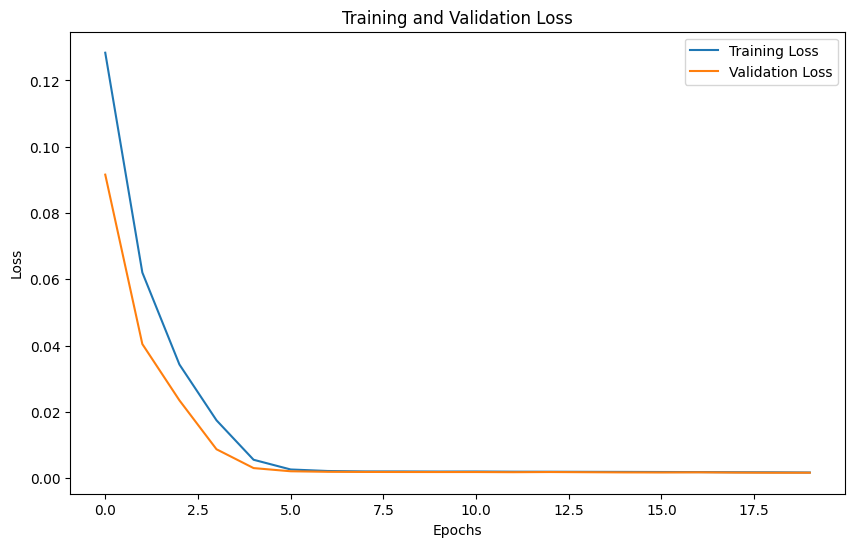

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
##############
#from scratch
##############

# Extract input and output from the DataFrame
X = np.vstack(df['X'].values)
P = df['Pression'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, P_train, P_test = train_test_split(X, P, test_size=0.2, random_state=42)






#input is P, output is X


# Normalize the input data
scaler_X = MinMaxScaler()
P_train_scaled = scaler_X.fit_transform(P_train)
P_test_scaled = scaler_X.transform(P_test)
# Normalize the output data
scaler_y = MinMaxScaler()
X_train_scaled = scaler_y.fit_transform(X_train)
X_test_scaled = scaler_y.transform(X_test)



# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),  # Input shape is 1 for pressure
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(X_train.shape[1], activation='linear')  # Output layer with linear activation for regression
])

alpha=0.5

# Define a custom loss function with Lagrangien term
def custom_loss(X_true, X_pred):
    mse_loss = tf.keras.losses.mean_squared_error(X_true, X_pred)
    
    #X=tf.convert_to_tensor(X_pred[0], dtype=tf.float32) #works all good
    #len(X_pred[0])= 78 good but  len(X_pred) = 16 LE BATCHE SIIIIIIIIIIIIIIIIIIIIZE
    
    #tf.print(X)   #<class 'tensorflow.python.framework.ops.SymbolicTensor'>
    
    #len(X_pred[0]) = 78
    #tf.print(tf.linalg.diag(X_pred[0][:39]))  #la découpe marche!!!!!!!!!!!!!
    
    #X=Keras.eval(X_pred[0])
    
    
    
    #X=tf.convert_to_tensor(X_pred[0])
    #Lag=Lagrangien(X, denseX0, denseM, denseK, P_train_tens[0], denseNsx, denseNsy) 

    
    
    
    
    # Combine MSE and Lagrangien terms
    total_loss = (1 - alpha)*mse_loss #+ alpha * Lagrangien(X_pred[0], X0, M, K, P, Nsx, Nsy)
    
    return total_loss








# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=custom_loss)




# Train the model
history = model.fit(P_train_scaled, X_train_scaled, epochs=20, batch_size=16, validation_split=0.2)

# Evaluate the model on the test set
#loss = model.evaluate(P_test_scaled, X_test_scaled)
#print(f'Test Loss: {loss}')

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()









In [3]:
#mse_pur  just mse
train_mse_pur=history.history['loss']
test_mse_pur=history.history['val_loss']

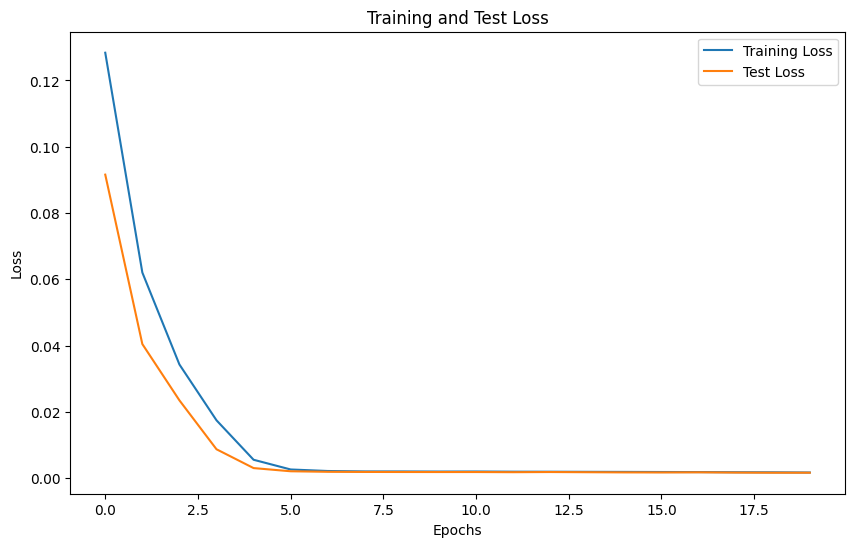

In [4]:
# Plot training loss and test loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [6]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ... (Votre code pour définir les fonctions nécessaires, comme Lagrangien)

# Sous-classe pour la perte physique
class TotalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def call(self, X_true, X_pred):
        mse_loss = tf.keras.losses.mean_squared_error(X_true, X_pred)

        # Récupérer les entrées nécessaires pour le calcul du Lagrangien
        P = self.P
        denseX0 = self.denseX0
        denseM = self.denseM
        denseK = self.denseK
        denseNsx = self.denseNsx
        denseNsy = self.denseNsy

        # Calculer le Lagrangien
        Lag = Lagrangien(X_pred[0], denseX0, denseM, denseK, P, denseNsx, denseNsy)#je pense qu'il faut 
                                                                                 #prendre le premier élément de X_pred
                                                                                 #ou encore la moyenne
        
        # Combinaison de la perte MSE et de la perte physique avec le Lagrangien
        total_loss = (1 - self.alpha) * mse_loss +self.alpha * Lag

        return total_loss

# ... (Votre code pour préparer les données)

# Charger les données nécessaires
denseM = np.load('denseM.npy')
denseNsx = np.load('denseNsx.npy')
denseNsy = np.load('denseNsy.npy')
denseX0 = np.load('X0.npy')
denseK = np.load('denseK.npy')

# Extract input and output from the DataFrame
X = np.vstack(df['X'].values)
P = df['Pression'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, P_train, P_test = train_test_split(X, P, test_size=0.2, random_state=42)

# Normalize the input data
scaler_X = MinMaxScaler()
P_train_scaled = scaler_X.fit_transform(P_train)
P_test_scaled = scaler_X.transform(P_test)

# Normalize the output data
scaler_y = MinMaxScaler()
X_train_scaled = scaler_y.fit_transform(X_train)
X_test_scaled = scaler_y.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),  # Input shape is 1 for pressure
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(X_train.shape[1], activation='linear')  # Output layer with linear activation for regression
])

# Créer une instance de la classe de perte physique
lagrangian_loss = TotalLoss(alpha=0.5)

# Définir les entrées physiques nécessaires dans la classe de perte
lagrangian_loss.P = P_train_scaled
lagrangian_loss.denseX0 = denseX0
lagrangian_loss.denseM = denseM
lagrangian_loss.denseK = denseK
lagrangian_loss.denseNsx = denseNsx
lagrangian_loss.denseNsy = denseNsy

# Compiler le modèle avec la nouvelle fonction de perte
model.compile(optimizer='adam', loss=lagrangian_loss)

# Entraîner le modèle
history = model.fit(P_train_scaled, X_train_scaled, epochs=30, batch_size=16, validation_split=0.2)

# ... (Votre code pour évaluer le modèle et tracer les courbes)


Epoch 1/30
40/40 [==============================] - 2s 12ms/step - loss: 0.2213 - val_loss: 0.1883
Epoch 2/30
40/40 [==============================] - 0s 4ms/step - loss: 0.1539 - val_loss: 0.1251
Epoch 3/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0936 - val_loss: 0.0672
Epoch 4/30
40/40 [==============================] - 0s 5ms/step - loss: 0.0693 - val_loss: 0.0980
Epoch 5/30
40/40 [==============================] - 0s 4ms/step - loss: 0.1008 - val_loss: 0.0932
Epoch 6/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0986 - val_loss: 0.0936
Epoch 7/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0760 - val_loss: 0.0647
Epoch 8/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0650 - val_loss: 0.0581
Epoch 9/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0582 - val_loss: 0.0522
Epoch 10/30
40/40 [==============================] - 0s 4ms/step - loss: 0.0469 - val_loss: 0.0382
Epoch 11/30
40/40 

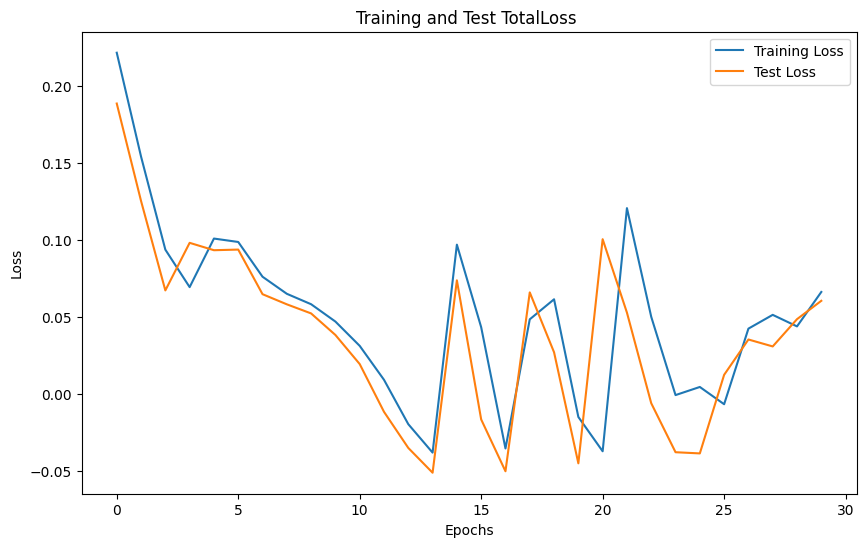

In [7]:
# Tracer les courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Test TotalLoss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Maitenant je vais garder le meme modèle/entrainement et tracer les loss séparement

In [8]:
#i found it hard to draw the 2 courbes independently so what im gonna do
#draw TotalLoss and TotalLoss-MSE  !!! GENIUS I KNOW


#historique de la SOMME
train_mse_physique=history.history['loss']
test_mse_physique=history.history['val_loss']


#ATTENTION à l'ordre d'exécution des cellules

#train_mse_pur=history.history['loss']
#test_mse_pur=history.history['val_loss']

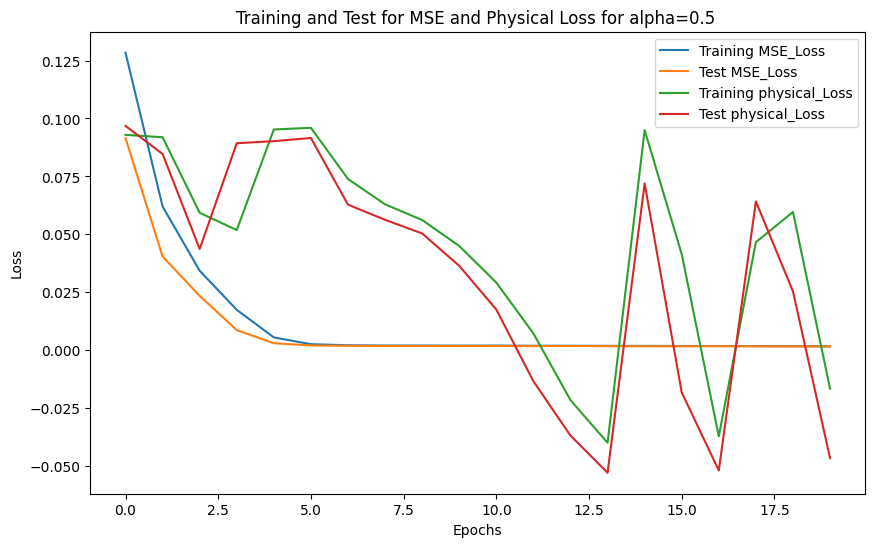

In [9]:
plt.figure(figsize=(10, 6))

#mse
plt.plot(train_mse_pur, label='Training MSE_Loss')
plt.plot(test_mse_pur, label='Test MSE_Loss')


#loss physique
plt.plot([item1 - item2 for item1, item2 in zip(train_mse_physique, train_mse_pur)], label='Training physical_Loss')
plt.plot([item1 - item2 for item1, item2 in zip(test_mse_physique, test_mse_pur)], label='Test physical_Loss')


plt.title('Training and Test for MSE and Physical Loss for alpha=0.5 ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
import time
# Normaliser la valeur d'entrée

input_value = 0.08
normalized_input = scaler_X.transform(np.array([[input_value]]))
start_time = time.time()

# Faire la prédiction
predicted_output_normalized = model.predict(normalized_input)

# Inverser la normalisation pour obtenir la prédiction dans l'échelle d'origine
predicted_output = scaler_y.inverse_transform(predicted_output_normalized)
end_time = time.time()
prediction_time = end_time - start_time

print("Prédiction pour la valeur d'entrée 0.08 :", predicted_output)


1/1 [==============================] - 0s 10ms/step
Prédiction pour la valeur d'entrée 0.08 : [[ 1.071193    0.9078475  -0.02973831 -0.03695006 -0.03847146 -0.0368539
  -0.03373745 -0.04031597 -0.03282946 -0.02489959 -0.01604404 -0.01547354
   0.0139959   0.0329825   0.05511711  0.07729503  0.10573845  0.13019586
   0.152014    0.18071617  0.21231374  0.24324656  0.27393737  0.31001914
   0.32958364  0.35927516  0.39647338  0.4368903   0.472974    0.5071534
   0.54194474  0.5752394   0.60752344  0.63754946  0.66456854  0.68737435
   0.7063143   0.7214898   0.03036257 -0.20404348  0.08277011 -0.34669513
  -0.31777897 -0.2860289  -0.25291592 -0.21887237 -0.18954714 -0.15410526
  -0.12220749 -0.09156038 -0.06703246 -0.03009057 -0.00271832  0.02801568
   0.05168336  0.08088252  0.09943325  0.11024474  0.12452017  0.14667886
   0.15041888  0.16351147  0.17863055  0.23255406  0.2729959   0.30064687
   0.31550303  0.31799838  0.30645376  0.28822142  0.26394263  0.23375894
   0.199426    0.160

In [13]:
prediction_time

0.055348873138427734

In [14]:
#choix de alpha par validation croisée 5-K
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold

# ... (Votre code pour définir les fonctions nécessaires, comme Lagrangien et TotalLoss)

# Charger les données nécessaires
denseM = np.load('denseM.npy')
denseNsx = np.load('denseNsx.npy')
denseNsy = np.load('denseNsy.npy')
denseX0 = np.load('X0.npy')
denseK = np.load('denseK.npy')

# Extract input and output from the DataFrame
X = np.vstack(df['X'].values)
P = df['Pression'].values.reshape(-1, 1)

# Normalize the input data
scaler_X = MinMaxScaler()
P_scaled = scaler_X.fit_transform(P)

# Normalize the output data
scaler_y = MinMaxScaler()
X_scaled = scaler_y.fit_transform(X)

# Définir les valeurs possibles de alpha à tester
alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]

# Initialiser KFold avec 5 plis
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Parcourir les différentes valeurs de alpha
for alpha in alpha_values:
    total_loss_values = []

    # Parcourir les plis
    for train_index, val_index in kf.split(P_scaled):
        P_train, P_val = P_scaled[train_index], P_scaled[val_index]
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]

        # Build the neural network model
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(1,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(X.shape[1], activation='linear')
        ])

        # Create an instance of the TotalLoss class
        total_loss = TotalLoss(alpha=alpha)

        # Set the necessary physical inputs in the loss class
        total_loss.P = P_train
        total_loss.denseX0 = denseX0
        total_loss.denseM = denseM
        total_loss.denseK = denseK
        total_loss.denseNsx = denseNsx
        total_loss.denseNsy = denseNsy

        # Compile the model with the new loss function
        model.compile(optimizer='adam', loss=total_loss)

        # Train the model
        model.fit(P_train, X_train, epochs=100, batch_size=16, verbose=0)

        # Evaluate the model on the validation set
        val_loss = model.evaluate(P_val, X_val, verbose=0)
        total_loss_values.append(val_loss)

    # Calculate the average validation loss for this alpha
    avg_val_loss = np.mean(total_loss_values)

    # Print or store the average validation loss for this alpha
    print(f'Alpha: {alpha}, Average Validation Loss: {avg_val_loss}')


Alpha: 0.1, Average Validation Loss: 0.08984764069318771
Alpha: 0.3, Average Validation Loss: -0.0005385275930166244
Alpha: 0.5, Average Validation Loss: -0.4910300552845001
Alpha: 0.7, Average Validation Loss: -0.9748968243598938
Alpha: 0.9, Average Validation Loss: -2.3643669366836546


In [17]:
#Ask the question: K-fold gives the choice of alpha that minimises the total loss, but
#the manual approach helps us choose an alpha that balances out the 2 parts MSE/Physical
#which is better/more important for us?

In [19]:
#Anyways
#According to K-fold, the better option is alpha=0.1
#So let's apply this value to our model

In [20]:
#ill do it in a separate notebook called neat

In [21]:
#Now K-fold to choose the number of neurons per hidden layer,  
#Of course, with alpha=0.1

In [23]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

# ... (Votre code pour définir les fonctions nécessaires, comme Lagrangien)

# Load the necessary data
denseM = np.load('denseM.npy')
denseNsx = np.load('denseNsx.npy')
denseNsy = np.load('denseNsy.npy')
denseX0 = np.load('X0.npy')
denseK = np.load('denseK.npy')

# Extract input and output from the DataFrame
X = np.vstack(df['X'].values)
P = df['Pression'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, P_train, P_test = train_test_split(X, P, test_size=0.2, random_state=42)

# Normalize the input data
scaler_X = MinMaxScaler()
P_train_scaled = scaler_X.fit_transform(P_train)
P_test_scaled = scaler_X.transform(P_test)

# Normalize the output data
scaler_y = MinMaxScaler()
X_train_scaled = scaler_y.fit_transform(X_train)
X_test_scaled = scaler_y.transform(X_test)

# Define the neural network model
def create_model(num_neurons_layer1, num_neurons_layer2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),  
        tf.keras.layers.Dense(num_neurons_layer1, activation='relu'),
        tf.keras.layers.Dense(num_neurons_layer2, activation='relu'),
        tf.keras.layers.Dense(X_train.shape[1], activation='linear')
    ])
    return model

# Perform K-fold cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

best_loss = float('inf')
best_num_neurons_layer1 = 0
best_num_neurons_layer2 = 0

for num_neurons_layer1 in [32, 64, 128]:
    for num_neurons_layer2 in [16, 32, 64]:
        avg_validation_loss = 0

        for train_index, val_index in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            P_train_fold, P_val_fold = P_train_scaled[train_index], P_train_scaled[val_index]

            model = create_model(num_neurons_layer1, num_neurons_layer2)
            lagrangian_loss = TotalLoss(alpha=0.1)

            # Set the necessary inputs in the loss class
            lagrangian_loss.P = P_train_fold
            lagrangian_loss.denseX0 = denseX0
            lagrangian_loss.denseM = denseM
            lagrangian_loss.denseK = denseK
            lagrangian_loss.denseNsx = denseNsx
            lagrangian_loss.denseNsy = denseNsy

            model.compile(optimizer='adam', loss=lagrangian_loss)

            # Train the model
            history = model.fit(P_train_fold, X_train_fold, epochs=30, batch_size=16, validation_split=0.2, verbose=0)

            # Compute validation loss
            val_loss = model.evaluate(P_val_fold, X_val_fold, verbose=0)
            avg_validation_loss += val_loss

        avg_validation_loss /= num_folds

        if avg_validation_loss < best_loss:
            best_loss = avg_validation_loss
            best_num_neurons_layer1 = num_neurons_layer1
            best_num_neurons_layer2 = num_neurons_layer2

# Print the best configuration
print(f"Best Number of Neurons in Layer 1: {best_num_neurons_layer1}")
print(f"Best Number of Neurons in Layer 2: {best_num_neurons_layer2}")
print(f"Best Average Validation Loss: {best_loss}")


Best Number of Neurons in Layer 1: 32
Best Number of Neurons in Layer 2: 64
Best Average Validation Loss: 0.013393433392047882


In [ ]:
#il faut inverser les deux couches

In [5]:
import numpy as np
#convertir les cst into tf tensors
#version tf des fonction
def T_Area(x1, x2, y1, y2):
    # Retourne l'aire du triangle formé par x et y
    #produit élément par élément
    a = 1/2 * abs(x1 * y2 - x2 * y1)
    return a


import tensorflow as tf


#supposons qu'on a déja K, M, Nsx, Nsy
denseM=np.load('denseM.npy')
denseNsx=np.load('denseNsx.npy')
denseNsy=np.load('denseNsy.npy')
denseX0=np.load('X0.npy')
denseK=np.load('denseK.npy')


def Lagrangien(X, denseX0, denseM, denseK, P, denseNsx, denseNsy):   #prend P et X comme paramètres
    #techniquement, P et X doivent déja etre en forme tensorielle, si ce n'est pas le casmodel, rectifier
    
    
    #X0 = tf.convert_to_tensor(denseX0, dtype=tf.float32)   #marche avec mais juste pour tester
    M = tf.convert_to_tensor(denseM, dtype=tf.float32)
    K = tf.convert_to_tensor(denseK, dtype=tf.float32)
    Nsx = tf.convert_to_tensor(denseNsx, dtype=tf.float32)
    Nsy = tf.convert_to_tensor(denseNsy, dtype=tf.float32)
    
    
    diagx= tf.slice(X, begin=[0], size=[39])
    diagy= tf.slice(X, begin=[39], size=[39])
    
 
    
    x = tf.linalg.diag(diagx)
    y = tf.linalg.diag(diagy)
    
    
    #these work but test other thing
    #diagx0= tf.constant(X0[:,0], dtype=tf.float32)
    #diagy0= tf.constant(X0[:,1], dtype=tf.float32)
    diagx0 = tf.constant(np.array(denseX0[:, 0]), dtype=tf.float32)
    diagy0 = tf.constant(np.array(denseX0[:, 1]), dtype=tf.float32)
    
    
    x0 = tf.linalg.diag(diagx0)
    y0 = tf.linalg.diag(diagy0)
    
    
    
    xv = x - x0
    yv = y - y0
    dx = tf.matmul(M, x) - tf.matmul(x, M)
    dy = tf.matmul(M, y) - tf.matmul(y, M)
    dx0 = tf.matmul(M, x0) - tf.matmul(x0, M)
    dy0 = tf.matmul(M, y0) - tf.matmul(y0, M)
    
    
    wt = 0.5 * tf.reduce_sum(K * ((tf.sqrt(dx**2 + dy**2) - tf.sqrt(dx0**2 + dy0**2))**2))

    # Calcul de l'énergie potentielle due à la pression du sang
    wp = 0.0
    Msb = tf.abs(Nsx) + tf.abs(Nsy) != 0  #booléen #Msb
    Ms= tf.cast(Msb, dtype=tf.float32)  # Matrice qui vaut 1 si le lien ij est en contact avec du sang

    O1 = 2*tf.cast((tf.matmul(Nsx,xv)+tf.matmul(Nsy,yv)> 0.0),dtype=tf.float32) - Ms
    wp += tf.reduce_sum(T_Area(tf.matmul(xv,M),dx,tf.matmul(yv,M),dy)*O1)


    O2= 2*tf.cast((tf.matmul(xv,Nsx)+tf.matmul(yv,Nsy)> 0.0),dtype=tf.float32) - Ms
    wp += tf.reduce_sum(T_Area(tf.matmul(xv,M),dx0,tf.matmul(yv,M),dy0) * O2)

    res = tf.reduce_sum(wt) - P * tf.reduce_sum(wp)
    return res



In [168]:
predictions=model(P_train)
P_train_tensor=tf.convert_to_tensor(P_train)

In [131]:
Lag=0
for i in range(78): 
    Lag+=Lagrangien(predictions[i], denseX0, denseM, denseK, P_train_tens[i], denseNsx, denseNsy) #yaaaaaaaaaaaas
    
print(Lag/78)    

tf.Tensor([0.12151931], shape=(1,), dtype=float32)


In [164]:
P_train_tensor

<tf.Tensor: shape=(800, 1), dtype=float64, numpy=
array([[0.00114303],
       [0.01177799],
       [0.02462586],
       [0.01303512],
       [0.04717085],
       [0.01560246],
       [0.00213959],
       [0.06883952],
       [0.0097947 ],
       [0.04463234],
       [0.00134937],
       [0.0019155 ],
       [0.07109709],
       [0.04525386],
       [0.02047912],
       [0.00459899],
       [0.02134663],
       [0.00315136],
       [0.06543586],
       [0.02614673],
       [0.00407953],
       [0.02947606],
       [0.08952657],
       [0.00125342],
       [0.06220049],
       [0.00100926],
       [0.01227691],
       [0.00501997],
       [0.06453715],
       [0.01183241],
       [0.00488302],
       [0.09772147],
       [0.00918254],
       [0.01416287],
       [0.0011643 ],
       [0.00115362],
       [0.00290043],
       [0.08470868],
       [0.00242317],
       [0.00464159],
       [0.00101393],
       [0.00256099],
       [0.01069126],
       [0.03977403],
       [0.00409838],
     

In [128]:
predictions   #<tf.Tensor: shape=(800, 78), dtype=float32,

<tf.Tensor: shape=(800, 78), dtype=float32, numpy=
array([[-9.7058341e-04, -9.8973699e-04,  9.6945190e-01, ...,
         8.5184023e-02,  2.7679572e-01,  4.0924242e-01],
       [-8.0925412e-04, -1.4190543e-03,  9.7276896e-01, ...,
         8.9227110e-02,  2.8195608e-01,  4.1637903e-01],
       [-6.9313403e-04, -7.4931979e-04,  9.6473020e-01, ...,
         1.0287660e-01,  2.9636639e-01,  4.3633366e-01],
       ...,
       [-6.2252022e-04, -7.1436539e-04,  9.2899698e-01, ...,
         1.5329576e-01,  3.3792379e-01,  4.9771300e-01],
       [-8.7525789e-04, -1.2434740e-03,  9.7141224e-01, ...,
         8.7573349e-02,  2.7984533e-01,  4.1345996e-01],
       [-9.6364506e-04, -1.0081921e-03,  9.6959448e-01, ...,
         8.5357852e-02,  2.7701756e-01,  4.0954924e-01]], dtype=float32)>

In [172]:
#Lagrangien(predictions[0], denseX0, denseM, denseK, P_train_tensor[0], denseNsx, denseNsy) NE MARCHE PAS CAR p8TRAIN_tensor 64
Lagrangien(predictions[0], denseX0, denseM, denseK, P_train_tens[0], denseNsx, denseNsy) #yaaaaaaaaaaaas

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0022977], dtype=float32)>

In [157]:
#Lagrangien(predictions, denseX0, denseM, denseK, P_train_tens, denseNsx, denseNsy)
#ne marche pas d'essayer de calculer lagrangien sur tout le tenseur

In [117]:
P_train_tens=tf.cast(P_train_tensor, dtype=tf.float32)

In [170]:
print(type(model.predict(P_train_scaled[:1])))

X_pred = model.predict(P_train_scaled[:1])
print(type(X_pred)) 

X_pred_full = X_pred[0]
print(len(X_pred_full)) 

1/1 [==============================] - 0s 41ms/step
<class 'numpy.ndarray'>
1/1 [==============================] - 0s 40ms/step
<class 'numpy.ndarray'>
78


In [152]:
X= df.at[100, 'X']
#len(X) good 78

x=X[:39]
y=X[39:]



#res = tf.concat([tf.expand_dims(x, axis=-1), tf.expand_dims(y, axis=-1)], axis=-1)
#res.numpy()

In [79]:
X_pred = model.predict(P_train_scaled[:1])
len(X_pred)  # Cela devrait imprimer <class 'numpy.ndarray'>


1/1 [==============================] - 0s 19ms/step


1